# Create two-dimensional projections of arbitrary lipid properties onto the membrane plane

Given certain lipid species are know to colocalise within membranes, and the fact that such aggregation will affect local membrane properties, it is often useful to know how the properties of a membrane change across the membrane plane.

In this notebook, we will look at how to create two-dimensional projections of lipid properties onto the membrane plane.

We will first prokect the ordered state ($\rm L_o$ and $\rm L_d$) of lipids onto the membrane plane. Then we will look at how to project the local membrane thicknesses onto the membrane plane, after calculating the local thicknesses using the membrane analysis tool [FATSLiM](http://fatslim.github.io/). In both cases, we wil be using a ternary mixture of DPPC, DOPC, and Cholesterol simulated by [Smith et al.](https://www.biorxiv.org/content/10.1101/2021.05.24.445501v3).


In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import MDAnalysis as mda
from lipyphilic.lib.plotting import ProjectionPlot


# Project lipid order state ($L_o$ or $L_d$) onto the membrane plane

## Load the topology and trajectory using MDAnalysis

In [2]:
u = mda.Universe("../datafiles/dppc-dopc-chol.tpr", "../datafiles/dppc-dopc-chol.xtc")

## Load the leaflet information

We want to project values onto each leaflet separately. Thus,we need to know which leaflet each lipid is in at each frame. We will use the results from the notebook on [assigning lipids to leaflets](2-AssignLeaflets.ipynb).


In [3]:
with open("../results/leaflets/leaflets-dppc-dopc-chol.pkl", 'rb') as f:
    leaflets = pickle.load(f)
    

## Load data on lipid order information

We also need to know whether each lipid at each frame is $L_d$ or $L_o$.

[In another tutorial](HiddenMarkovModel.ipynb), we construct a hidden Markov model based on lipid thicknesses in order to determine whether each lipid in each frame is liquid-ordered ($L_o$) or liquid-disordered ($L_d$). 


In [4]:
# Load the lipid order data
filename = "../results/HMM/lipid-order.npy"
lipid_order = np.load(filename)


`lipid_order` is a two-dimensional NumPy. Like many analyses in **lipyphilic**, the array is of shape ($N_{\rm lipids}$, $N_{\rm lipids}$) The:

- rows correspond to individual lipids
- columns correspond to individual frames.

In the array, the ordered state of each lipid is defined as follows:

- values of 1 indicate the lipid is in the $L_o$ state
- values of -1 indicate the lipid is in the $L_d$ state

Let's look at the array:


In [5]:
lipid_order

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1]], dtype=int8)

We see the first lipid (first row) is $L_o$ both at the beginning and end of the frames used in the analysis.

The second lipid (second row) is $L_o$ at the beginning of the analysis but $L_d$ at the end.



## Plot the ordered state in x and y

We must pass the $xy$ positions of our lipids in the upper leaflet, as well as their ordered state, to `ProjectionPlot`.

We will use the data from the final frame only.


In [6]:
# load the final frame coordaintes into memory
frame_index = -1
u.trajectory[frame_index]  

# select all lipids in the membrane
membrane = u.select_atoms("resname DPPC DOPC CHOL").residues

# calculate the center of mass of each lipid
x_pos, y_pos, _ = membrane.center_of_mass(compound="residues").T


We want to include only lipids in the upper leaflet. We will therefore filter the coordinates and lipid order data based on the leaflet membership:

In [7]:
# use the upper leaflet positions only
upper_mask = (leaflets.leaflets[:, frame_index] == 1)

# filter the coordinates
upper_x_pos = x_pos[upper_mask]
upper_y_pos = y_pos[upper_mask]
upper_lipid_order = lipid_order[upper_mask, frame_index]


We can now create our `ProjectionPlot` object:

In [8]:
projection = ProjectionPlot(
    x_pos=upper_x_pos,
    y_pos=upper_y_pos,
    values=upper_lipid_order
)


Then project these lipid order data onto the membrane plane. For this, we can specificy how to bin the $xy$ coordinates into a two-dimensional histgram:

In [9]:
# We will create 1 x 1 Angstrom bins that covers the entire range of the system in xy
bins = np.linspace(0, u.dimensions[0], int(np.ceil(u.dimensions[0]) + 1))


In [10]:
projection.project_values(bins=bins)

Before creating the plot, we will use interpolate missing values and remove NaN values:

In [11]:
projection.interpolate(method="linear")

Now we will plot the two-dimensional distribution

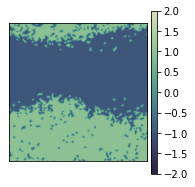

In [12]:
projection.plot_projection(
)

## Adjusting the aesthetics

Our generated plot has a continuous colourscale, even though we have discrete values (-1 and 1).

There are many options that we can use to control the aesthetics of out plot. Below we will look at some of these options, including how to create a discrete colourmap.


In [13]:
# Create a colormap
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="new_cmap",
    colors=["xkcd:red", "xkcd:sky blue"]
)

# ensure the colourmap is discrete by defining its bounds
bounds=[-1, 0, 1]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


Below, we will also plot both the upper and lower leaflet projection on the same figure.


In [14]:
# define titles for each subfigure
titles = ["Upper", "Lower"]


/home/paul/git-repos/lipyphilic/src/lipyphilic/lib/plotting.py:277: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self._imshow = plt.imshow(


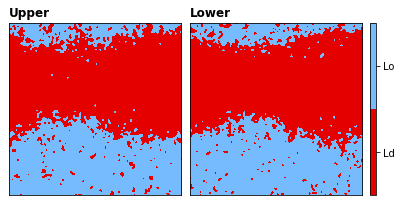

In [15]:
# Create our figure with two subfigures
fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

# iterate over the two leaflets
for index, leaflet in enumerate([-1, 1]):
    
    # Create the projection plot for this leaflet
    # Use only the positions and lipid order data of lipids in the current leaflet
    projection = ProjectionPlot(
        x_pos[leaflets.leaflets[:, frame_index] == leaflet],
        y_pos[leaflets.leaflets[:, frame_index] == leaflet],
        lipid_order[:, frame_index][leaflets.leaflets[:, frame_index] == leaflet]
    )
    
    # project values
    projection.project_values(bins=bins)
    
    # interpolate
    projection.interpolate(method="linear")
    
    # only add a colour bar for one subfigure
    cbar = False if leaflet == -1 else True
    
    # Plot the distribution
    projection.plot_projection(
        ax=axes[index],
        title=titles[index],
        cmap=cmap,                  # use the colourmap we defined
        imshow_kws={"norm": norm},  # make the colourmap discrete
        cbar=cbar
    )

# reduce the horizontal spacing between the subfigures
plt.tight_layout(w_pad=-15)

# Add sensible labels to the colourbar
projection.cbar.set_ticks([-0.5, 0.5])
projection.cbar.set_ticklabels(["Ld", "Lo"])


There is a clear separation between the $L_o$ and $L_d$ regions.

# Project local membrane thicknesses onto the membrane plane

The local membrane thickness was calculated using [FATSLiM](https://pythonhosted.org/fatslim/documentation/thickness.html). The following command was run in the `../datafiles` directory:

```
fatslim thickness -c dppc-dopc-chol.gro -t dppc-dopc-chol.xtc -n dppc-dopc-headgroups.ndx --export-thickness-raw ../results/FATSLiM-thickness/membrane-thickness- --end-frame 1
```

We use the output of this command to projetion local membrane thicknesses onto the membrane plane.


## Load the thickness data

In [16]:
filename = "../results/FATSLiM-thickness/membrane-thickness-frame-00000.csv"

In [17]:
df = pd.read_csv(filename)


In [18]:
df.head()

,resid,leaflet,X coords,Y coords,Z coords,Thickness
0,8001,lower leaflet,21.209,40.710,1.907,3.875
1,8002,lower leaflet,11.936,13.348,1.877,4.319
2,8003,lower leaflet,45.144,42.117,2.082,3.515
3,8004,lower leaflet,5.371,27.568,2.330,3.875
4,8005,lower leaflet,47.781,21.739,1.641,3.786


This DataFrame contains the local membrane thickness for each lipid in each leaflet. We will use only the information for lipids in the upper leaflet:


In [19]:
df = df.loc[df.leaflet == "upper leaflet"]

In [20]:
df.head()

,resid,leaflet,X coords,Y coords,Z coords,Thickness
4000,2001,upper leaflet,35.289,51.328,6.163,4.166
4001,2002,upper leaflet,40.708,32.563,5.974,3.894
4002,2003,upper leaflet,23.919,30.001,6.272,4.193
4003,2004,upper leaflet,32.416,31.120,6.126,4.028
4004,2005,upper leaflet,27.297,7.735,6.246,4.383


## Extract the $x$ and $y$ positions and local membrane thicknesses

In [21]:
x_pos = df["X coords"]
y_pos = df["Y coords"]
thickness = df["Thickness"]


These values are all in nm. We will convert to Å before plotting:

In [22]:
x_pos *= 10
y_pos *= 10
thickness *= 10


## Plot the membrane thickness

Create our plotting object:

In [23]:
thickness_projection = ProjectionPlot(
    x_pos=x_pos,
    y_pos=y_pos,
    values=thickness
)
    

Determine the bins to use for the two-dimensional histogram. The thickness calculation was perfomred on the first frame only, so we will use the system dimensions at this frame to generate the bins:

In [24]:
# load the first frame coordaintes into memory
frame_index = -1
u.trajectory[frame_index]  

# We will create 1 x 1 Angstrom bins that covers the entire range of the system in xy
bins = np.linspace(0, u.dimensions[0], int(np.ceil(u.dimensions[0]) + 1))


As before, we will project the values onto the membrane plane, interpolate to fill in missing values, then create the plot.


In [25]:
thickness_projection.project_values(bins=bins)
thickness_projection.interpolate()


We will use a range of 30 Å to 50 Å for our colourbar.

In [26]:
vmin = 30
vmax = 50

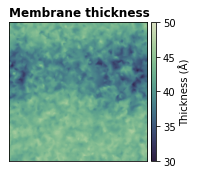

In [27]:
thickness_projection.plot_projection(
    title="Membrane thickness",
    vmin=vmin,
    vmax=vmax,
    cbar_kws={"shrink":0.85, "label": "Thickness (Å)"}  # make the colourbar smaller
)

# Add sensible tick spacing to the colourbar
thickness_projection.cbar.set_ticks(np.arange(30, 51, 5))


The thickest and thinnest parts of the membrane correspond to the $L_o$ and $L_d$ regions, respectively.